In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F


In [5]:
from utils import interleave, de_interleave, show_batch, AverageMeter, show_grid, get_config
from learner import FixMatch, CoMatch, SupLearning
from dataset import get_data
from build import build_model

In [6]:
# config = get_config('./configs/local_semisupervised_mock_groupbycat.yaml')
config = get_config('./configs/local_semisupervised.yaml')

In [7]:
df_anno = pd.read_csv(config['DATA']['ANNO'])
df_unanno = None
df_anno.head()

,image,target,is_valid,is_labeled
0,upper-gi-tract/anatomical-landmarks/retroflex-...,15,False,True
1,upper-gi-tract/anatomical-landmarks/z-line/233...,10,False,True
2,lower-gi-tract/pathological-findings/ulcerativ...,21,False,True
3,upper-gi-tract/anatomical-landmarks/pylorus/ad...,9,False,True
4,lower-gi-tract/quality-of-mucosal-views/bbps-0...,1,False,True


In [8]:
# df_anno['is_valid']

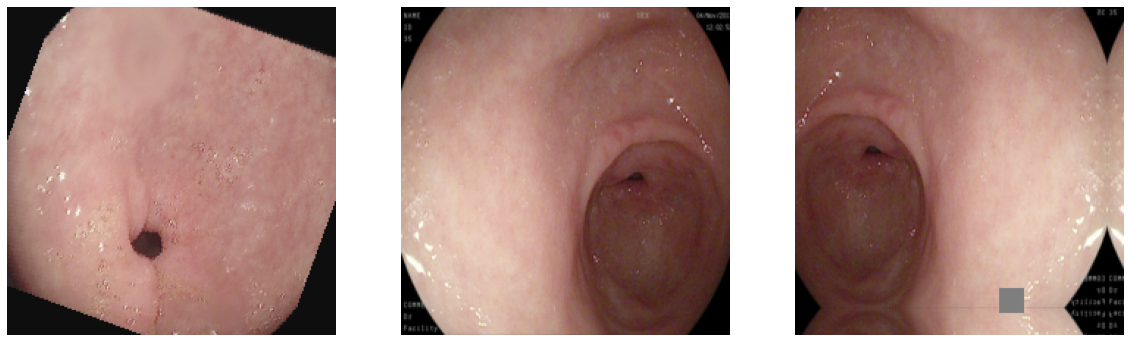

In [9]:
# train_dl, valid_dl = get_data(config, df_anno, df_unanno, is_visual=True)
train_dl, valid_dl = get_data(config, df_anno, df_unanno,is_full_sup = False, is_visual=True, type_semi = config.MODEL.TYPE_SEMI)

In [10]:
model = build_model(config)

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
if config.TRAIN.IS_SSL:
    if config.MODEL.TYPE_SEMI == 'FixMatch':
        classifier = FixMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
    else:
        classifier = CoMatch(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
else:
    classifier = SupLearning(model = model,
                          opt_func=config['TRAIN']['OPT_NAME'], 
                          device = device)
classifier.get_dataloader(train_dl, valid_dl)
classifier.get_config(config)

100%|██████████████████████████████████████████████| 668/668 [1:10:32<00:00,  6.34s/it, loss=0.557]


Metric:
{'micro/precision': 0.8379542899962533, 'micro/recall': 0.8379542899962533, 'micro/f1': 0.8379542899962532, 'macro/precision': 0.5515342733681983, 'macro/recall': 0.5429031406134062, 'macro/f1': 0.533610458373495}
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.14      0.12        21
           1       0.96      0.92      0.94       323
           2       0.94      0.97      0.96       574
           3       0.86      0.87      0.87       501
           4       0.87      0.86      0.87       495
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         5
           7       0.78      0.97      0.86        66
           8       0.94      0.96      0.95       505
           9       0.97      0.98      0.98       500
          10       0.71      0.93      0.80       466
          11       0.42      0.35      0.38       202
          12       0.74      0.19      0.30       13

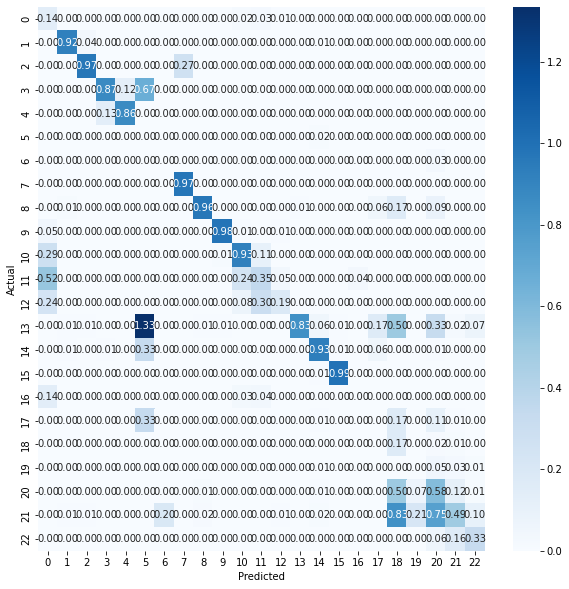

(<utils.AverageMeter at 0x239b53c7390>,
 {'micro/precision': 0.8379542899962533,
  'micro/recall': 0.8379542899962533,
  'micro/f1': 0.8379542899962532,
  'macro/precision': 0.5515342733681983,
  'macro/recall': 0.5429031406134062,
  'macro/f1': 0.533610458373495})

In [13]:
classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\sup_densenet161\\06_18_2022_15_00_47_epoch_105_sup_1_9.pth')
classifier.evaluate_one(True, True, True)

In [24]:
# classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\\semi_resnet50\\05_31_2022_20_08_43_mock_1_9_ce.pth')
# classifier.evaluate_one(True, True, True)

In [25]:
# classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\semi_resnet50\\05_31_2022_21_26_03_mock_2_8_ce.pth')
# classifier.evaluate_one(True, True, True)

100%|██████████████████████████████████████████████████| 67/67 [04:05<00:00,  3.66s/it, loss=0.927]


Metric:
{'micro/precision': 0.7069943289224953, 'micro/recall': 0.7069943289224953, 'micro/f1': 0.7069943289224953, 'macro/precision': 0.3922153570024564, 'macro/recall': 0.3910623529737725, 'macro/f1': 0.3891977842970807}
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.12      0.15         8
           1       0.55      0.63      0.59        27
           2       0.25      0.20      0.22        10
           3       0.36      0.40      0.38        45
           4       0.97      0.95      0.96       204
           5       0.00      0.00      0.00         3
           6       0.60      0.58      0.59        91
           7       0.17      0.14      0.15         7
           8       0.23      0.30      0.26        10
           9       0.65      0.75      0.69        71
          10       0.00      0.00      0.00         1
          11       0.73      0.62      0.67        52

    accuracy                           0.71       

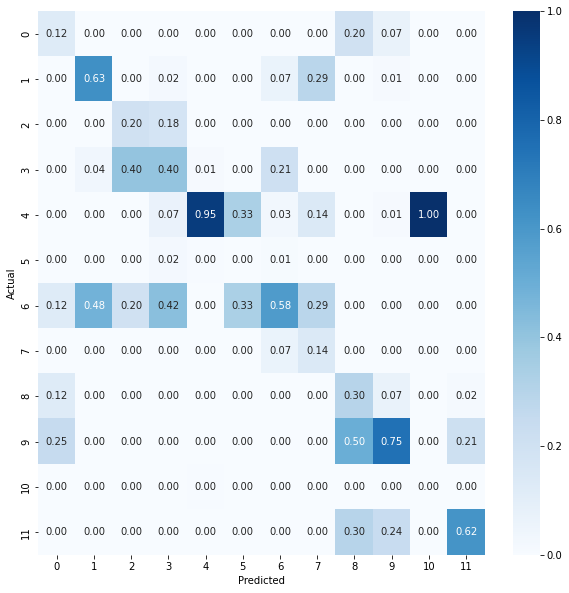

(<utils.AverageMeter at 0x154a6775390>,
 {'micro/precision': 0.7069943289224953,
  'micro/recall': 0.7069943289224953,
  'micro/f1': 0.7069943289224953,
  'macro/precision': 0.3922153570024564,
  'macro/recall': 0.3910623529737725,
  'macro/f1': 0.3891977842970807})

In [19]:
classifier.load_checkpoint('D:\\model\\endoscopy\\hyper_kvasir\\sup_densenet161\\06_14_2022_14_14_15_sup_2_8.pth')
classifier.evaluate_one(True, True, True)

In [ ]:
# classifier.fit()

In [ ]:
# classifier.save_checkpoint('./')